# Analysis of scRNA-seq data 3 (Velocyto)

In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import pandas as pd
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

2019-06-13 00:31:32,437 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-06-13 00:31:32,445 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [3]:
!mkdir data

mkdir: data: File exists


# Load data

# Change sample names

In [197]:
ds = loompy.connect("allRamDA.loom")
# This file was created from BAM files according to instruction of Velocyto.

In [198]:
ds.layer.keys()

['', 'ambiguous', 'spanning', 'spliced', 'unspliced']

In [199]:
print(ds.col_attrs['CellID']);
np.shape(ds.col_attrs['CellID'])

['allRamDA:EWF-E12_FJW160809001_A01_ACTCGCT-TCGACTA_L001_trim.sort.bam'
 'allRamDA:EWF-E12_FJW160809001_A02_GGAGCTA-TCGACTA_L001_trim.sort.bam'
 'allRamDA:EWF-E12_FJW160809001_A03_GCGTAGT-TCGACTA_L001_trim.sort.bam'
 ... 'allRamDA:mEWFK14-E12_FJW180314001_CH10_S190_R1_001_trim.sort.bam'
 'allRamDA:mEWFK14-E12_FJW180314001_CH11_S191_R1_001_trim.sort.bam'
 'allRamDA:mEWFK14-E12_FJW180314001_CH12_S192_R1_001_trim.sort.bam']


(1908,)

In [200]:
import re

In [201]:
i=0
for item in ds.col_attrs['CellID']:
    #print(item)
    ds.col_attrs['CellID'][i]=re.sub("allRamDA:EWF-|allRamDA:mEWF-|allRamDA:|_[A-Z]{7,8}-[A-Z]{7,8}_L[0-9]{3}_trim.sort.bam|_S[0-9]{1,3}_R1_[0-9]{3}_trim.sort.bam","",item)
    i+=1

In [202]:
print(ds.col_attrs['CellID'][1:50])

['E12_FJW160809001_A02' 'E12_FJW160809001_A03' 'E12_FJW160809001_A04'
 'E12_FJW160809001_A05' 'E12_FJW160809001_A06' 'E12_FJW160809001_A07'
 'E12_FJW160809001_A08' 'E12_FJW160809001_A09' 'E12_FJW160809001_A10'
 'E12_FJW160809001_A11' 'E12_FJW160809001_B02' 'E12_FJW160809001_B03'
 'E12_FJW160809001_B04' 'E12_FJW160809001_B05' 'E12_FJW160809001_B06'
 'E12_FJW160809001_B07' 'E12_FJW160809001_B08' 'E12_FJW160809001_B09'
 'E12_FJW160809001_B10' 'E12_FJW160809001_B11' 'E12_FJW160809001_B12'
 'E12_FJW160809001_C01' 'E12_FJW160809001_C02' 'E12_FJW160809001_C03'
 'E12_FJW160809001_C04' 'E12_FJW160809001_C05' 'E12_FJW160809001_C06'
 'E12_FJW160809001_C07' 'E12_FJW160809001_C08' 'E12_FJW160809001_C09'
 'E12_FJW160809001_C10' 'E12_FJW160809001_C11' 'E12_FJW160809001_C12'
 'E12_FJW160809001_D01' 'E12_FJW160809001_D02' 'E12_FJW160809001_D04'
 'E12_FJW160809001_D05' 'E12_FJW160809001_D06' 'E12_FJW160809001_D07'
 'E12_FJW160809001_D08' 'E12_FJW160809001_D09' 'E12_FJW160809001_D10'
 'E12_FJW160809001_D

In [203]:
print(ds.col_attrs['CellID'][850:900])

['PDIS2025-088' 'PDIS2025-089' 'PDIS2025-090' 'PDIS2025-091'
 'PDIS2025-092' 'PDIS2025-093' 'PDIS2025-094' 'PDIS2025-095'
 'PDIS2025-096' 'PDIS2025-097' 'PDIS2025-098' 'PDIS2025-099'
 'PDIS2025-100' 'PDIS2025-101' 'PDIS2025-102' 'PDIS2025-103'
 'PDIS2025-104' 'PDIS2025-105' 'PDIS2025-106' 'PDIS2025-107'
 'PDIS2025-108' 'PDIS2025-109' 'PDIS2025-110' 'PDIS2025-111'
 'PDIS2025-112' 'PDIS2025-113' 'PDIS2025-114' 'PDIS2025-115'
 'PDIS2025-116' 'PDIS2025-117' 'PDIS2025-118' 'PDIS2025-119'
 'PDIS2025-120' 'PDIS2025-121' 'PDIS2025-122' 'PDIS2025-123'
 'PDIS2025-124' 'PDIS2025-125' 'PDIS2025-126' 'PDIS2025-127'
 'PDIS2025-128' 'PDIS2025-129' 'PDIS2025-130' 'PDIS2025-131'
 'PDIS2025-132' 'PDIS2025-133' 'PDIS2025-134' 'PDIS2025-135'
 'PDIS2025-136' 'PDIS2025-137']


In [204]:
sample_info=pd.read_table("Yokohama_sample_names_subset.txt",header=0)
sample_info.head(5)

sample_no stage        plate well        sample_id seq_place  \
0         97   E15  Y02_E15_002  A01  Y02_E15_002_A01  yokohama   
1         98   E15  Y02_E15_002  A02  Y02_E15_002_A02  yokohama   
2         99   E15  Y02_E15_002  A03  Y02_E15_002_A03  yokohama   
3        100   E15  Y02_E15_002  A04  Y02_E15_002_A04  yokohama   
4        101   E15  Y02_E15_002  A05  Y02_E15_002_A05  yokohama   

            sample_name      Riken_ID     Riken_ID1      Riken_ID2  \
0  E15_FJW161014002_A01  PDIS2025.097  PDIS2025-097  PDIS2025-0097   
1  E15_FJW161014002_A02  PDIS2025.098  PDIS2025-098  PDIS2025-0098   
2  E15_FJW161014002_A03  PDIS2025.099  PDIS2025-099  PDIS2025-0099   
3  E15_FJW161014002_A04  PDIS2025.100  PDIS2025-100  PDIS2025-0100   
4  E15_FJW161014002_A05  PDIS2025.101  PDIS2025-101  PDIS2025-0101   

      celltype  LDYield_nM  num_processed  percent_mapped  mapped_read  \
0  Y02_E15_002   23.465054        2229907       43.785324       976372   
1  Y02_E15_002   18.758896        2474699       41.383700      1024122   
2  Y02_E15_002   21.588146        2412518       37.144676       896122   
3  Y02_E15_002   24.767289        1870638       41.875285       783335   
4  Y02_E15_002   27.280773        2151250       41.156583       885381   

   sample_no.1  
0           97  
1           98  
2           99  
3          100  
4          101

In [205]:
i=0
for item in sample_info["Riken_ID1"]:
    j=0
    for name in ds.col_attrs['CellID']:
        if item == name:
            ds.col_attrs['CellID'][j]=re.sub(item,sample_info.loc[i,"sample_name"],name)
        j+=1
    i+=1

In [206]:
print(ds.col_attrs['CellID'][850:900])

['PDIS2025-088' 'PDIS2025-089' 'PDIS2025-090' 'PDIS2025-091'
 'PDIS2025-092' 'PDIS2025-093' 'PDIS2025-094' 'PDIS2025-095'
 'PDIS2025-096' 'E15_FJW161014002_A01' 'E15_FJW161014002_A02'
 'E15_FJW161014002_A03' 'E15_FJW161014002_A04' 'E15_FJW161014002_A05'
 'E15_FJW161014002_A06' 'E15_FJW161014002_A07' 'E15_FJW161014002_A08'
 'E15_FJW161014002_A09' 'E15_FJW161014002_A10' 'E15_FJW161014002_A11'
 'PDIS2025-108' 'E15_FJW161014002_B01' 'E15_FJW161014002_B02'
 'E15_FJW161014002_B03' 'E15_FJW161014002_B04' 'E15_FJW161014002_B05'
 'PDIS2025-114' 'E15_FJW161014002_B07' 'E15_FJW161014002_B08'
 'E15_FJW161014002_B09' 'E15_FJW161014002_B10' 'E15_FJW161014002_B11'
 'E15_FJW161014002_B12' 'E15_FJW161014002_C01' 'E15_FJW161014002_C02'
 'E15_FJW161014002_C03' 'E15_FJW161014002_C04' 'E15_FJW161014002_C05'
 'E15_FJW161014002_C06' 'E15_FJW161014002_C07' 'E15_FJW161014002_C08'
 'E15_FJW161014002_C09' 'E15_FJW161014002_C10' 'E15_FJW161014002_C11'
 'E15_FJW161014002_C12' 'E15_FJW161014002_D01' 'E15_FJW1610140

In [300]:
print(ds.col_attrs.keys())
print(ds.row_attrs.keys())
print(ds.layer.keys())

['CellID']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['', 'ambiguous', 'spanning', 'spliced', 'unspliced']


In [195]:
#ds.close()

## Extract epithelial cells

In [337]:
seurat = loompy.connect("AllEpithelialCells_RamDA_Seurat.loom")
# This file was created from Seurat object 

In [338]:
print(seurat.col_attrs.keys())
print(seurat.row_attrs.keys())
print(seurat.layer.keys())

['CellID', 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'cell_names', 'labelmod_res_1', 'labelmod_res_2', 'labelmod_res_2_3', 'labelmod_res_2_added', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'oldIdent', 'old_ident', 'orig_ident', 'originalIdent', 'percent_mito', 'plate', 'res_0_1', 'res_0_2', 'res_0_3', 'res_0_4', 'res_0_5', 'res_0_6', 'res_0_7', 'res_0_8', 'res_0_9', 'res_1', 'res_1_1', 'res_1_2', 'res_1_3', 'res_1_4', 'res_1_5', 'res_1_6', 'res_1_7', 'res_1_8', 'res_1_9', 'res_2', 'res_2_1', 'res_2_2', 'res_2_3', 'res_2_4', 'sampling_date', 'stage', 'stage_new', 'tSNE_1', 'tSNE_2', 'well']
['Gene', 'Selected', 'gene_names']
['', 'norm_data', 'scale_data']


In [292]:
seurat.close()

In [381]:
print(np.shape(ds[:, :]))
print(np.shape(seurat[:, :]))
#print(np.shape(ds[:,seurat.col_attrs['CellID']]))

(51826, 1908)
(47630, 962)


In [339]:
#seurat.col_attrs.keys()
seurat.col_attrs['CellID'][0:5]

array(['E12_FJW160809003_BA01', 'E12_FJW160809003_BA02',
       'E12_FJW160809003_BA03', 'E12_FJW160809003_BA04',
       'E12_FJW160809003_BA05'], dtype=object)

In [265]:
ds.row_attrs['Gene']

array(['Xkr4', 'Gm37180', 'Gm37363', ..., 'Mid1-ps1', 'Erdr1', 'Gm21742'],
      dtype='<U16')

In [267]:
#seurat.row_attrs.keys()
seurat.row_attrs['Gene']

array(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', ..., 'Zyx',
       'Zzef1', 'Zzz3'], dtype=object)

In [294]:
seurat.col_attrs['ClusterID'][0:5]

array(['1', '1', '1', '1', '1'], dtype=object)

In [359]:
index=seurat.col_attrs['CellID'].tolist()
i=0
for item in seurat.col_attrs['CellID'].tolist():
    index[i]=ds.col_attrs['CellID'].tolist().index(item)
    i+=1
print(index[0:5])

[1435, 1436, 1437, 1438, 1439]


In [ ]:
#ds["spliced"][:, sorted(index)]

In [374]:
col_attrs = { "CellID": ds.col_attrs['CellID'][sorted(index)] }
loompy.create("AllEpithelialCells_RamDA_Velocyto.loom", 
              ds["spliced"][:, sorted(index)], 
              row_attrs=ds.row_attrs, 
              col_attrs=col_attrs)

In [375]:
dsNew = loompy.connect("AllEpithelialCells_RamDA_Velocyto.loom")
print(dsNew.col_attrs.keys())
print(dsNew.row_attrs.keys())
print(dsNew.layer.keys())

['CellID']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['']


In [379]:
dsNew.layers['ambiguous']=ds['ambiguous'][:, sorted(index)]
dsNew.layers['spanning']=ds['spanning'][:, sorted(index)]
dsNew.layers['spliced']=ds['spliced'][:, sorted(index)]
dsNew.layers['unspliced']=ds['unspliced'][:, sorted(index)]

In [380]:
print(dsNew.layer.keys())
#['', 'ambiguous', 'spanning', 'spliced', 'unspliced']

['', 'spliced', 'ambiguous', 'spanning', 'unspliced']


In [383]:
index=seurat.col_attrs['CellID'].tolist()
i=0
for item in dsNew.col_attrs['CellID'].tolist():
    index[i]=seurat.col_attrs['CellID'].tolist().index(item)
    i+=1
print(index[0:5])

[246, 239, 242, 223, 224]


In [389]:
dsNew.ca.stage_new=seurat.col_attrs['stage_new'][index]
dsNew.ca.stage=seurat.col_attrs['stage'][index]
dsNew.ca.Phase=seurat.col_attrs['Phase'][index]
dsNew.ca.ClusterID=seurat.col_attrs['ClusterID'][index]
dsNew.ca.tSNE_1=seurat.col_attrs['tSNE_1'][index]
dsNew.ca.tSNE_2=seurat.col_attrs['tSNE_2'][index]
dsNew.ca.well=seurat.col_attrs['well'][index]
print(dsNew.col_attrs.keys())

['CellID', 'stage_new', 'stage', 'Phase', 'ClusterID', 'tSNE_1', 'tSNE_2', 'well']


In [393]:
print(dsNew.col_attrs.keys())
print(dsNew.row_attrs.keys())
print(dsNew.layer.keys())

['CellID', 'ClusterID', 'Phase', 'stage', 'stage_new', 'tSNE_1', 'tSNE_2', 'well']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['', 'ambiguous', 'spanning', 'spliced', 'unspliced']


In [394]:
dsNew.close()

# Load data and start velocyto

In [192]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("AllEpithelialCells_RamDA_Velocyto.loom")

In [193]:
print(vlm.ca.keys())
print(vlm.ra.keys())

dict_keys(['CellID', 'ClusterID', 'Phase', 'stage', 'stage_new', 'tSNE_1', 'tSNE_2', 'well'])
dict_keys(['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand'])


In [194]:
print(np.shape(vlm.ra["Gene"]))

(51826,)


2019-06-13 02:08:55,492 - DEBUG - update_title_pos
2019-06-13 02:08:55,509 - DEBUG - update_title_pos
2019-06-13 02:08:55,533 - DEBUG - update_title_pos
2019-06-13 02:08:55,554 - DEBUG - update_title_pos
2019-06-13 02:08:55,565 - DEBUG - update_title_pos


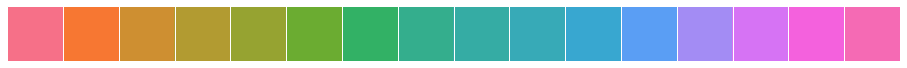

In [195]:
import seaborn as sns; sns.set()
sns.palplot(sns.color_palette("husl",16))

In [196]:
sns.color_palette("husl",16)[1]

(0.9688417625390765, 0.46710871459052145, 0.1965441952393453)

In [197]:
# Read column attributes form the loom file and specify colors
vlm.ts = np.column_stack([vlm.ca["tSNE_1"], vlm.ca["tSNE_2"]])
colors_dict = {'0': sns.color_palette("husl",16)[0], 
               '1': sns.color_palette("husl",16)[1], 
               '2': sns.color_palette("husl",16)[2],
               '3': sns.color_palette("husl",16)[3], 
               '4': sns.color_palette("husl",16)[4], 
               '5': sns.color_palette("husl",16)[5],
               '6': sns.color_palette("husl",16)[6], 
               '7': sns.color_palette("husl",16)[7],  
               '8': sns.color_palette("husl",16)[8],
               '9': sns.color_palette("husl",16)[9], 
               '10': sns.color_palette("husl",16)[10], 
               '11': sns.color_palette("husl",16)[11],
               '12': sns.color_palette("husl",16)[12], 
               '13': sns.color_palette("husl",16)[13],
               '14': sns.color_palette("husl",16)[14],
               '15': sns.color_palette("husl",16)[15]}
vlm.set_clusters(vlm.ca["ClusterID"], cluster_colors_dict=colors_dict)

In [198]:
vlm.ca["Clusters"]=np.vectorize(int)(vlm.ca["ClusterID"])

2019-06-13 02:09:04,465 - DEBUG - update_title_pos
2019-06-13 02:09:04,492 - DEBUG - update_title_pos
2019-06-13 02:09:04,535 - DEBUG - update_title_pos
2019-06-13 02:09:04,560 - DEBUG - update_title_pos
2019-06-13 02:09:04,576 - DEBUG - update_title_pos


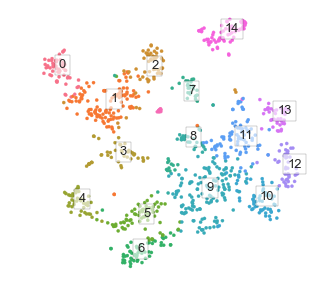

In [199]:
# Plot TSNE
plt.figure(figsize=(5,5))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=10)
#for i in range(max(vlm.ca["ClusterID"])):
for i in range(max(vlm.ca["Clusters"])):
    ts_m = np.median(vlm.ts[vlm.ca["Clusters"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["Clusters"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

In [200]:
#vlm.plot_fractions()

# Velocity Analysis

In [201]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))

In [202]:
vlm.ts = np.column_stack([vlm.ca["tSNE_1"], vlm.ca["tSNE_2"]])

In [203]:
vlm.set_clusters(vlm.ca["ClusterID"])

In [204]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20)
vlm.filter_genes(by_detection_levels=True)

2019-06-13 02:09:21,889 - DEBUG - Filtering by detection level


In [205]:
print(np.shape(vlm.ra["Gene"]))

(21034,)


In [180]:
vlm.ra["Gene"]['Nfatc1']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

2019-06-13 02:09:35,596 - DEBUG - svr_gamma set to 0.007874429103889968
2019-06-13 02:09:48,498 - DEBUG - Filtering by cv vs mean
2019-06-13 02:09:48,519 - DEBUG - update_title_pos
2019-06-13 02:09:48,563 - DEBUG - update_title_pos
2019-06-13 02:09:48,606 - DEBUG - update_title_pos
2019-06-13 02:09:48,727 - DEBUG - update_title_pos
2019-06-13 02:09:48,795 - DEBUG - update_title_pos


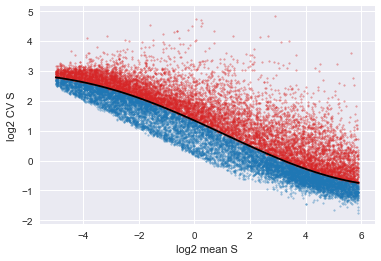

In [206]:
vlm.score_cv_vs_mean(10000, plot=True, max_expr_avg=60)
#vlm.score_cv_vs_mean(8000, plot=True, max_expr_avg=10, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=5)
vlm.filter_genes(by_cv_vs_mean=True)

In [207]:
print(np.shape(vlm.ra["Gene"]))

(10001,)


In [208]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2019-06-13 02:10:57,955 - INFO - Cluster: 0 (54 cells)
2019-06-13 02:10:57,964 - INFO - Cluster: 1 (120 cells)
2019-06-13 02:10:57,979 - INFO - Cluster: 10 (62 cells)
2019-06-13 02:10:57,988 - INFO - Cluster: 11 (81 cells)
2019-06-13 02:10:57,998 - INFO - Cluster: 12 (45 cells)
2019-06-13 02:10:58,005 - INFO - Cluster: 13 (40 cells)
2019-06-13 02:10:58,022 - INFO - Cluster: 14 (67 cells)
2019-06-13 02:10:58,031 - INFO - Cluster: 15 (11 cells)
2019-06-13 02:10:58,048 - INFO - Cluster: 2 (56 cells)
2019-06-13 02:10:58,056 - INFO - Cluster: 3 (43 cells)
2019-06-13 02:10:58,064 - INFO - Cluster: 4 (46 cells)
2019-06-13 02:10:58,071 - INFO - Cluster: 5 (71 cells)
2019-06-13 02:10:58,080 - INFO - Cluster: 6 (58 cells)
2019-06-13 02:10:58,090 - INFO - Cluster: 7 (41 cells)
2019-06-13 02:10:58,097 - INFO - Cluster: 8 (27 cells)
2019-06-13 02:10:58,114 - INFO - Cluster: 9 (136 cells)
2019-06-13 02:10:58,132 - DEBUG - Filtering by cluster expression
2019-06-13 02:10:58,133 - DEBUG - Filtering by

In [209]:
print(np.shape(vlm.ra["Gene"]))

(8146,)


In [210]:
# original normalization parameter
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

In [189]:
vlm.initial_cell_size

array([387907, 539097, 462767, 441686, 549456, 376818, 378458, 495311,
       538983, 445008, 545867, 483186, 523020, 344192, 492422, 353347,
       488350, 474304, 481415, 481045, 462516, 489719, 367232, 484329,
       467176, 476030, 539311, 503084, 537547, 311363, 578140, 356583,
       470762, 503441, 625905, 467200, 572718, 540140, 614144, 524600,
       518234, 479680, 514950, 455967, 622595, 623909, 546856, 585972,
       546688, 497039, 527067, 538006, 447918, 542752, 599650, 604065,
       557186, 543268, 466863, 500896, 606124, 422790, 598047, 471582,
       532835, 673702, 465327, 551122, 441877, 448334, 725542, 542355,
       424412, 505828, 697918, 573831, 443748, 431355, 401924, 453502,
       450839, 531066, 280330, 504651, 481651, 490122, 432822, 495588,
       376127, 541502, 542935, 505519, 420398, 666839, 562241, 521027,
       429405, 542474, 429519, 464413, 467198, 449326, 503952, 576633,
       376855, 580557, 551189, 566273, 429401, 442680, 517647, 559333,
      

In [18]:
# best with sample and expression scaling
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))
#### initial_cell_size (int) – The sum of spliced molecules

32

2019-06-14 15:12:52,657 - DEBUG - update_title_pos
2019-06-14 15:12:52,705 - DEBUG - update_title_pos
2019-06-14 15:12:52,743 - DEBUG - update_title_pos
2019-06-14 15:12:52,791 - DEBUG - update_title_pos
2019-06-14 15:12:52,815 - DEBUG - update_title_pos


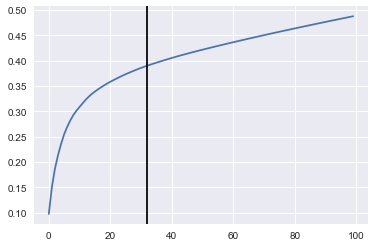

In [211]:
# Preparation for gamma fit
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [212]:
k = 24 #(number of neighbors. If None the default it is chosen to be 0.025 * Ncells)
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2019-06-14 15:12:59,330 - DEBUG - First search the 192 nearest neighbours for 958
2019-06-14 15:12:59,445 - DEBUG - Using the initialization network to find a 24-NN graph with maximum connectivity of 96
2019-06-14 15:12:59,449 - DEBUG - Returning sparse matrix


In [213]:
#Defalt
vlm.fit_gammas()
#Tutorial
#vlm.fit_gammas(limit_gamma=False, fit_offset=False)

In [214]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [20]:
np.where(vlm.ra["Gene"] == "Tnc")

(array([1682]),)

In [21]:
np.where(vlm.ra["Gene"] == "Tnc")[0]

array([1682])

In [22]:
np.where(vlm.ra["Gene"] == "Tnc")[0][0]

1682

In [191]:
print(np.shape(vlm.ra["Gene"]))
print(vlm.ra["Gene"])

(8146,)
['Xkr4' 'Mybl1' 'Tcf24' ... 'Eif2s3y' 'Mid1-ps1' 'Erdr1']


In [165]:
print(vlm.ca.keys())
print(vlm.ra.keys())

dict_keys(['CellID', 'ClusterID', 'Phase', 'stage', 'stage_new', 'tSNE_1', 'tSNE_2', 'well', 'Clusters'])
dict_keys(['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand'])


2019-06-14 15:14:36,603 - DEBUG - update_title_pos
2019-06-14 15:14:36,632 - DEBUG - update_title_pos
2019-06-14 15:14:36,653 - DEBUG - update_title_pos
2019-06-14 15:14:36,675 - DEBUG - update_title_pos
2019-06-14 15:14:36,692 - DEBUG - update_title_pos
2019-06-14 15:14:36,700 - DEBUG - Assigning font /b'F1' = '/Library/Fonts/Microsoft/Arial.ttf'
2019-06-14 15:14:36,720 - DEBUG - update_title_pos
2019-06-14 15:14:36,766 - DEBUG - update_title_pos
2019-06-14 15:14:36,798 - DEBUG - update_title_pos
2019-06-14 15:14:36,832 - DEBUG - Embedding font /Library/Fonts/Microsoft/Arial.ttf.
2019-06-14 15:14:36,833 - DEBUG - Writing TrueType font.
2019-06-14 15:14:36,961 - DEBUG - update_title_pos
2019-06-14 15:14:36,981 - DEBUG - update_title_pos
2019-06-14 15:14:37,018 - DEBUG - update_title_pos
2019-06-14 15:14:37,046 - DEBUG - update_title_pos
2019-06-14 15:14:37,073 - DEBUG - update_title_pos
2019-06-14 15:14:37,092 - DEBUG - update_title_pos
2019-06-14 15:14:37,131 - DEBUG - update_title_po

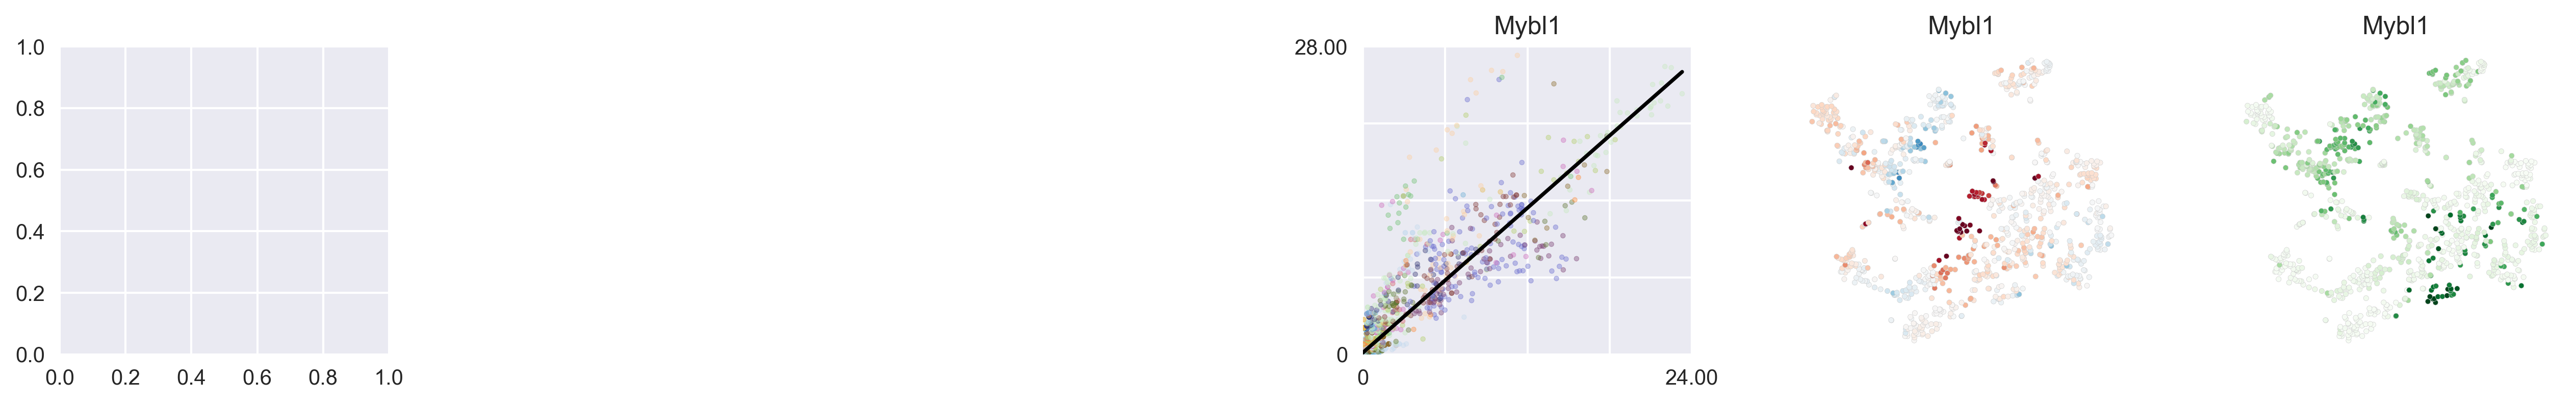

In [215]:
plt.figure(None, (17,2.8), dpi=300)
gs = plt.GridSpec(1,6)
for i, gn in enumerate(["Nfatc1","Mybl1"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    # Plot velocity as color on the Tsne embedding
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=6, alpha=1, rasterized=True)
    # Plot expression as color on the Tsne embedding
    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=6, alpha=1, rasterized=True)
    
plt.tight_layout()
plt.savefig("Fig3_selection.pdf")

2019-06-14 15:14:44,378 - DEBUG - update_title_pos
2019-06-14 15:14:44,407 - DEBUG - update_title_pos
2019-06-14 15:14:44,426 - DEBUG - update_title_pos
2019-06-14 15:14:44,441 - DEBUG - update_title_pos
2019-06-14 15:14:44,469 - DEBUG - update_title_pos
2019-06-14 15:14:44,487 - DEBUG - update_title_pos
2019-06-14 15:14:44,501 - DEBUG - update_title_pos
2019-06-14 15:14:44,526 - DEBUG - update_title_pos
2019-06-14 15:14:44,544 - DEBUG - update_title_pos
2019-06-14 15:14:44,559 - DEBUG - update_title_pos
2019-06-14 15:14:44,582 - DEBUG - update_title_pos
2019-06-14 15:14:44,600 - DEBUG - update_title_pos
2019-06-14 15:14:44,615 - DEBUG - update_title_pos
2019-06-14 15:14:44,635 - DEBUG - update_title_pos
2019-06-14 15:14:44,657 - DEBUG - update_title_pos
2019-06-14 15:14:44,671 - DEBUG - update_title_pos
2019-06-14 15:14:44,696 - DEBUG - update_title_pos
2019-06-14 15:14:44,721 - DEBUG - update_title_pos
2019-06-14 15:14:44,735 - DEBUG - update_title_pos
2019-06-14 15:14:44,754 - DEBUG

2019-06-14 15:14:51,022 - DEBUG - update_title_pos
2019-06-14 15:14:51,056 - DEBUG - update_title_pos
2019-06-14 15:14:51,084 - DEBUG - update_title_pos
2019-06-14 15:14:51,110 - DEBUG - update_title_pos
2019-06-14 15:14:51,144 - DEBUG - update_title_pos
2019-06-14 15:14:51,171 - DEBUG - update_title_pos
2019-06-14 15:14:51,199 - DEBUG - update_title_pos
2019-06-14 15:14:51,234 - DEBUG - update_title_pos
2019-06-14 15:14:51,260 - DEBUG - update_title_pos
2019-06-14 15:14:51,288 - DEBUG - update_title_pos
2019-06-14 15:14:51,326 - DEBUG - update_title_pos
2019-06-14 15:14:51,349 - DEBUG - update_title_pos


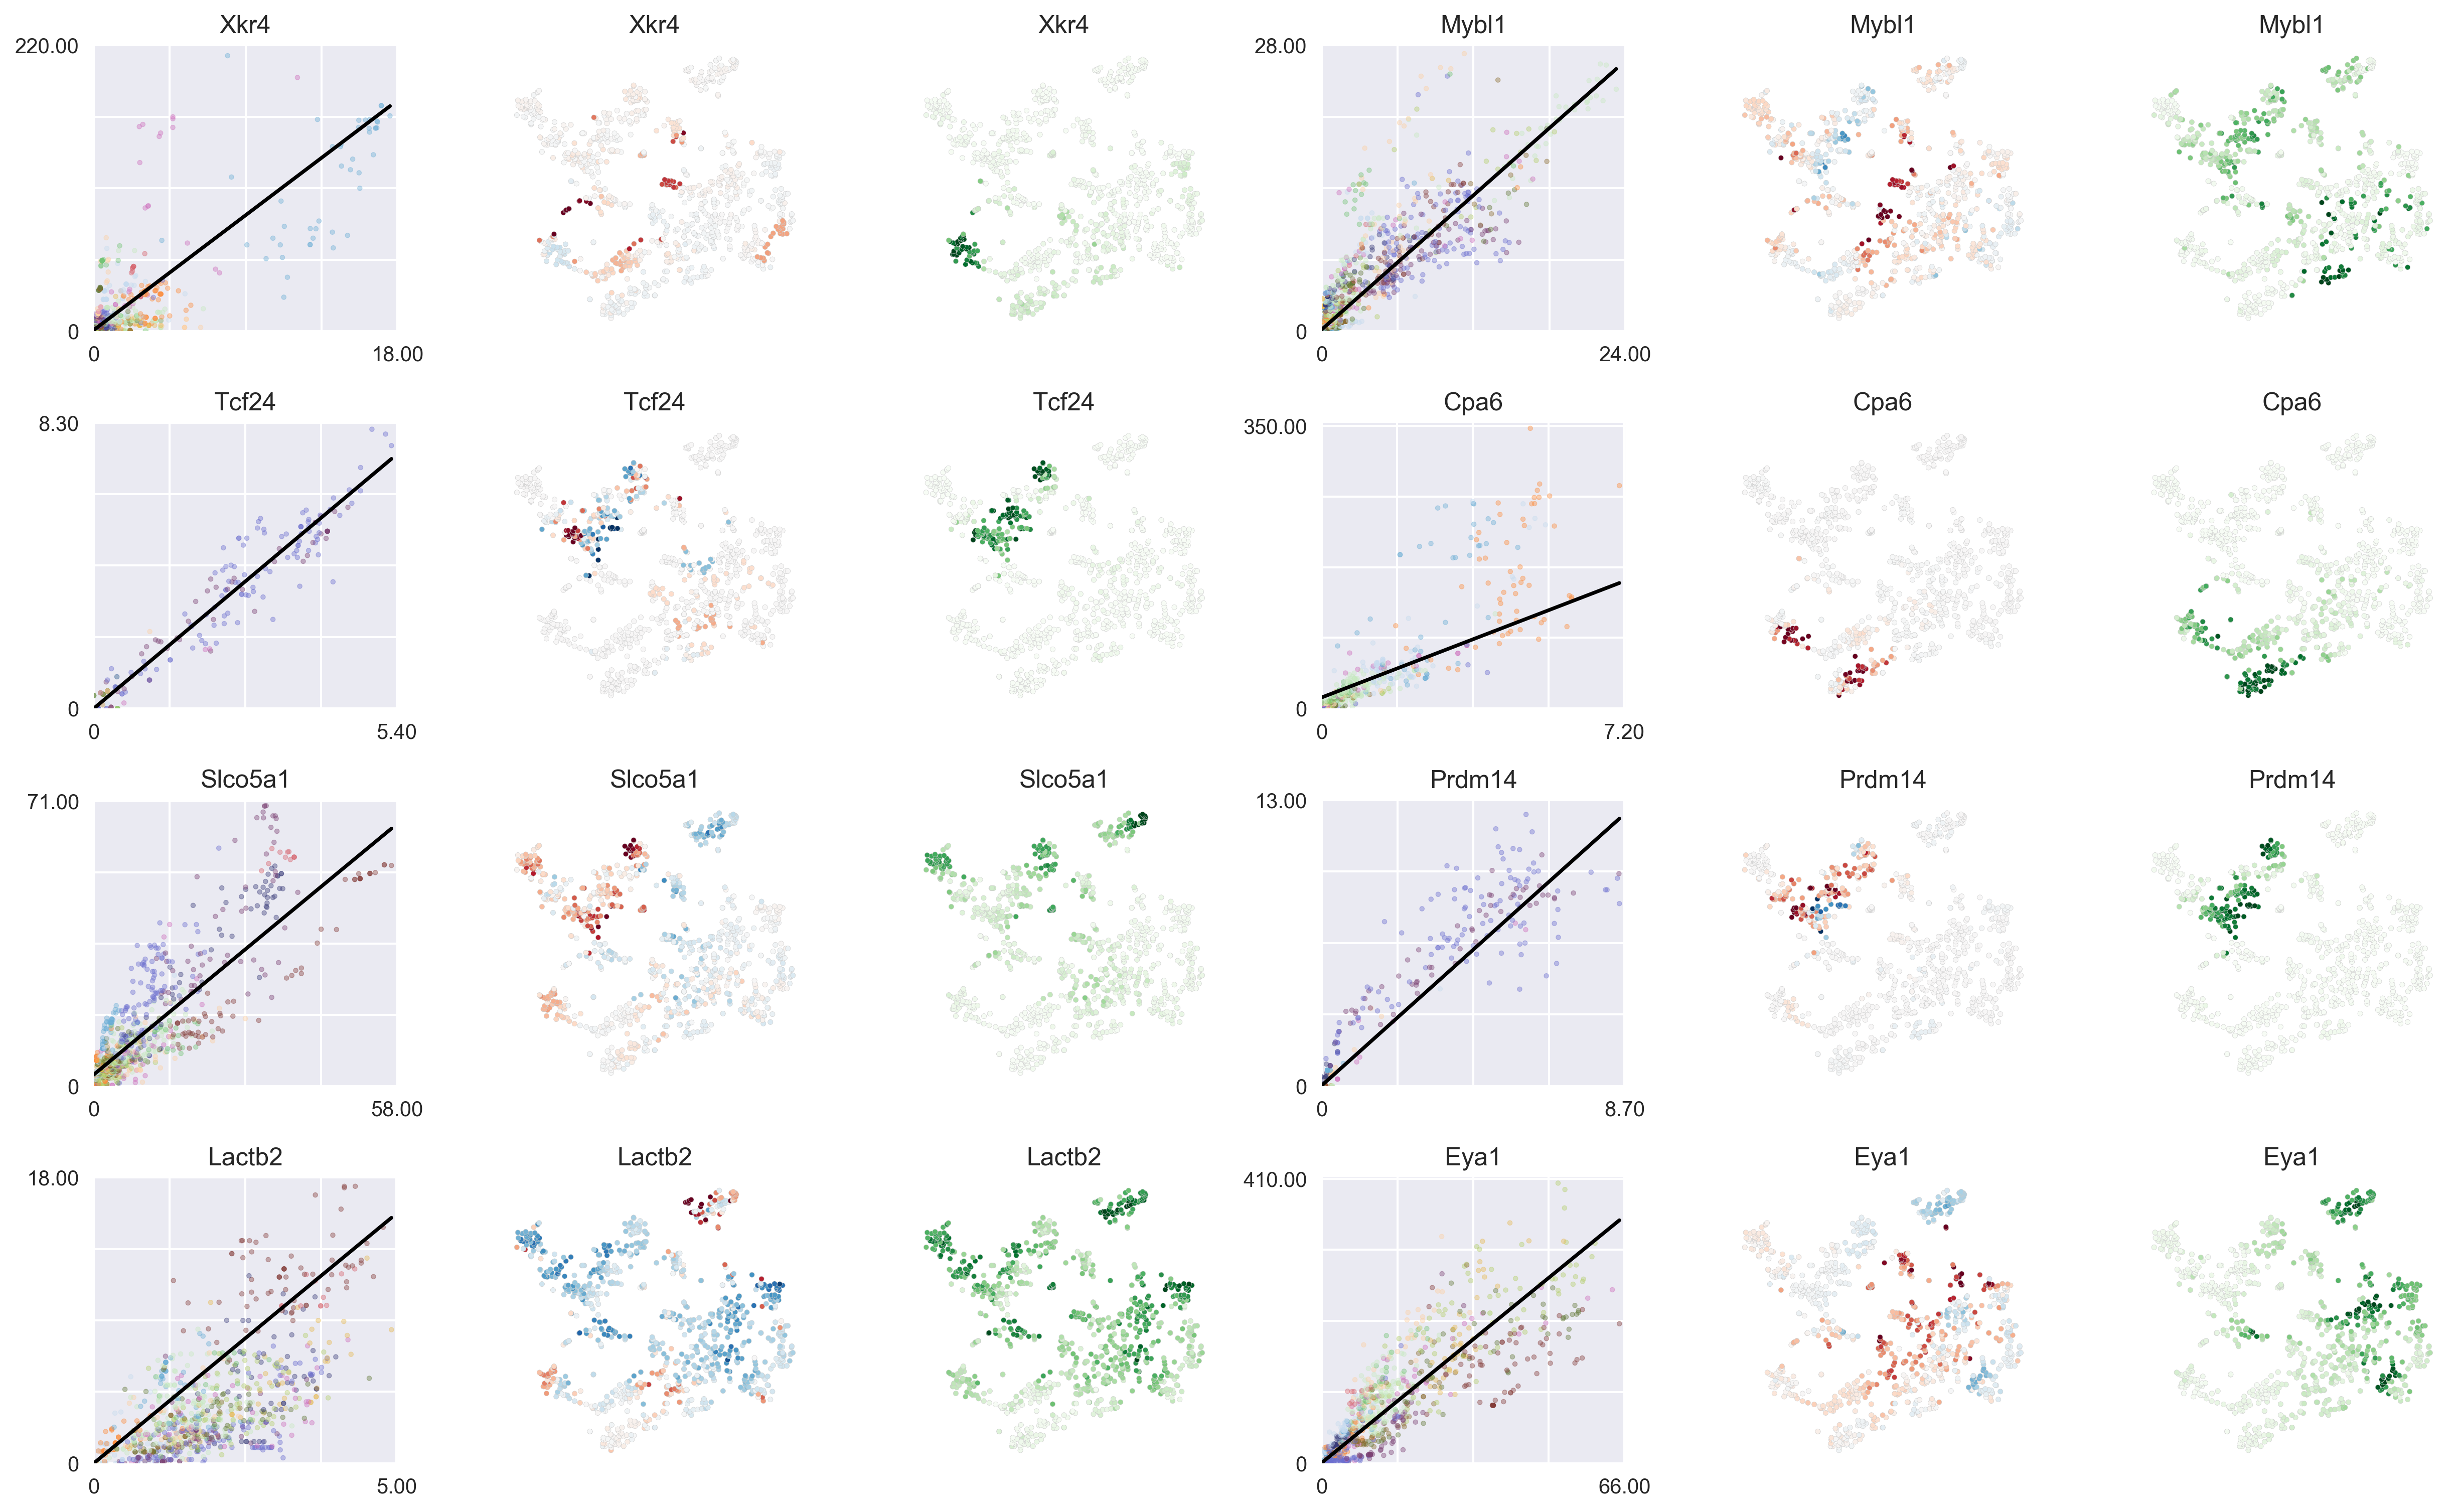

In [216]:
plt.figure(None, (16.5,15), dpi=300)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(vlm.ra["Gene"][0:8]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], alpha=1, s=6, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], alpha=1, s=6, rasterized=True)
    
plt.tight_layout()
plt.savefig("Suppl_phase_selection.pdf")

In [217]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=0.5)

2019-06-14 15:15:21,982 - DEBUG - Calculate KNN in the embedding space
2019-06-14 15:15:22,282 - DEBUG - Correlation Calculation 'knn_random'


/Users/fujiwaralab/.pyenv/versions/anaconda3-4.0.0/envs/myenv/lib/python3.6/site-packages/velocyto/analysis.py:1562: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


2019-06-14 15:15:35,020 - DEBUG - Correlation Calculation for negative control
2019-06-14 15:16:05,437 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2019-06-14 15:16:05,440 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2019-06-14 15:16:05,441 - DEBUG - Done Correlation Calculation


In [218]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=100)

#n_neighbors – number of neighbors to use in the calculation, 
#bigger number should not change too much the results.. …as soon as smooth is small Higher value correspond to slower execution time

2019-06-14 15:16:23,230 - DEBUG - Calculate transition probability
2019-06-14 15:16:23,245 - DEBUG - Calculate transition probability for negative control


2019-06-14 15:16:30,027 - DEBUG - update_title_pos
2019-06-14 15:16:30,334 - DEBUG - update_title_pos
2019-06-14 15:16:30,367 - DEBUG - update_title_pos
2019-06-14 15:16:30,439 - DEBUG - update_title_pos
2019-06-14 15:16:30,465 - DEBUG - update_title_pos
2019-06-14 15:16:30,485 - DEBUG - update_title_pos


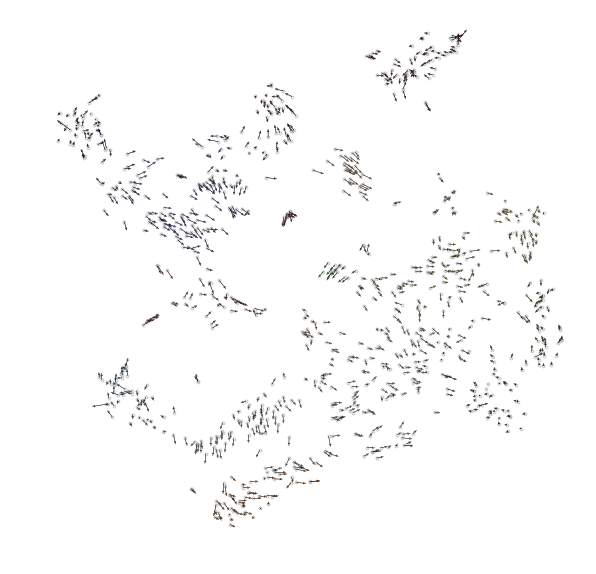

In [219]:
plt.figure(None,(10,10))
quiver_scale = 60

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("full_arrows.pdf")

2019-06-20 19:10:37,637 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots
2019-06-20 19:10:37,673 - DEBUG - update_title_pos
2019-06-20 19:10:37,699 - DEBUG - update_title_pos
2019-06-20 19:10:37,725 - DEBUG - update_title_pos
2019-06-20 19:10:37,744 - DEBUG - update_title_pos
2019-06-20 19:10:37,832 - DEBUG - update_title_pos
2019-06-20 19:10:37,856 - DEBUG - update_title_pos
2019-06-20 19:10:37,884 - DEBUG - update_title_pos
2019-06-20 19:10:37,906 - DEBUG - update_title_pos
2019-06-20 19:10:37,924 - DEBUG - update_title_pos
2019-06-20 19:10:37,949 - DEBUG - update_title_pos


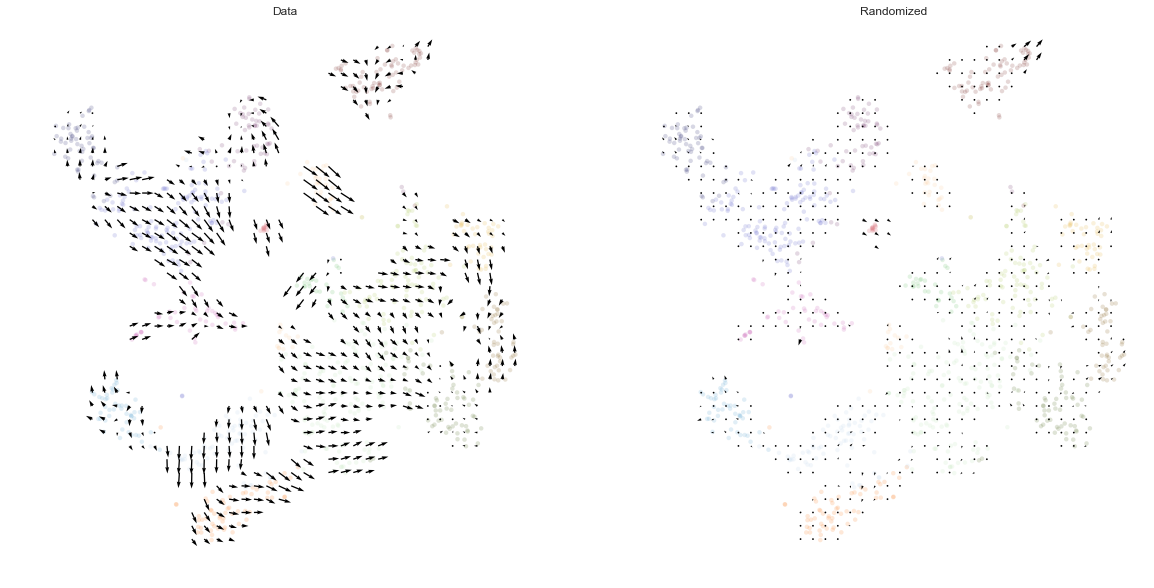

In [238]:
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)
plt.figure(None,(20,10))
#vlm.plot_grid_arrows(quiver_scale='auto',plot_random=True,scale_type='relative')
vlm.plot_grid_arrows(quiver_scale=0.6,plot_random=True,scale_type="absolute")

#vlm.plot_grid_arrows(quiver_scale='auto',
#                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, 
#                    min_mass=24, angles='xy', scale_units='xy',
#                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
#                    plot_random=True, scale_type='relative')

2019-06-20 19:14:27,013 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots
2019-06-20 19:14:27,050 - DEBUG - update_title_pos
2019-06-20 19:14:27,080 - DEBUG - Assigning font /b'F1' = '/Library/Fonts/Microsoft/Arial.ttf'
2019-06-20 19:14:27,158 - DEBUG - update_title_pos
2019-06-20 19:14:27,256 - DEBUG - Embedding font /Library/Fonts/Microsoft/Arial.ttf.
2019-06-20 19:14:27,258 - DEBUG - Writing TrueType font.
2019-06-20 19:14:27,343 - DEBUG - update_title_pos
2019-06-20 19:14:27,377 - DEBUG - update_title_pos
2019-06-20 19:14:27,410 - DEBUG - update_title_pos
2019-06-20 19:14:27,446 - DEBUG - update_title_pos
2019-06-20 19:14:27,553 - DEBUG - update_title_pos
2019-06-20 19:14:27,577 - DEBUG - update_title_pos
2019-06-20 19:14:27,602 - DEBUG - update_title_pos
2019-06-20 19:14:27,617 - DEBUG - update_title_pos
2019-06-20 19:14:27,633 - DEBUG - update_title_pos
2019-06-20 19:14:27,665 - DEBUG - update_title_pos


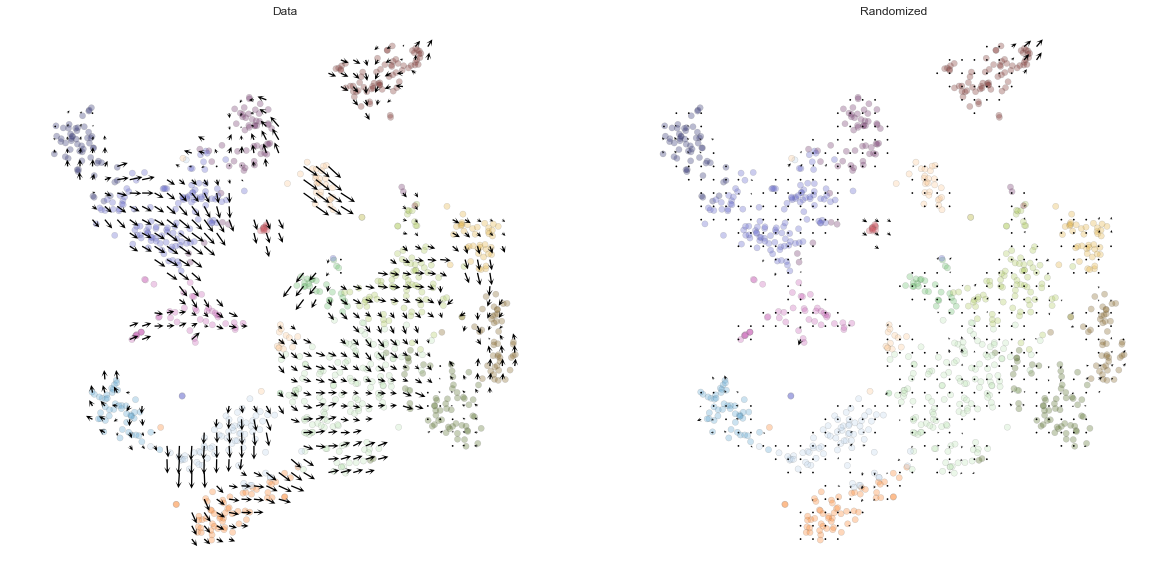

In [244]:
# initial divide by mean
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.6,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, 
                     min_mass=1, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=True, scale_type="absolute")
plt.savefig("vectorfield.pdf")

## Markov chain

2019-06-20 19:54:49,479 - DEBUG - update_title_pos
2019-06-20 19:54:49,524 - DEBUG - update_title_pos
2019-06-20 19:54:49,580 - DEBUG - update_title_pos
2019-06-20 19:54:49,613 - DEBUG - update_title_pos
2019-06-20 19:54:49,635 - DEBUG - update_title_pos


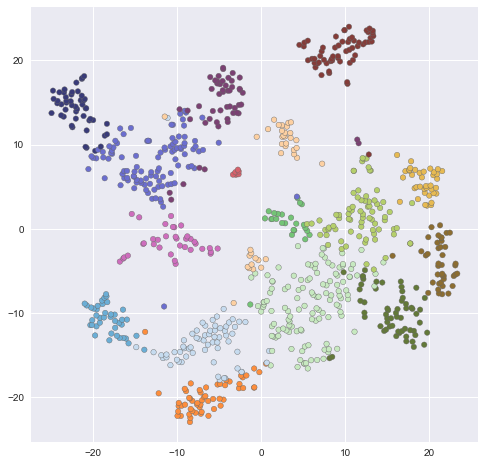

In [253]:
# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
steps = 100, 100
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")

In [254]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='forward', cells_ixs=ixs)

In [255]:
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

2019-06-20 19:55:12,098 - DEBUG - update_title_pos
2019-06-20 19:55:12,121 - DEBUG - update_title_pos
2019-06-20 19:55:12,134 - DEBUG - update_title_pos
2019-06-20 19:55:12,173 - DEBUG - update_title_pos
2019-06-20 19:55:12,193 - DEBUG - update_title_pos
2019-06-20 19:55:12,209 - DEBUG - update_title_pos


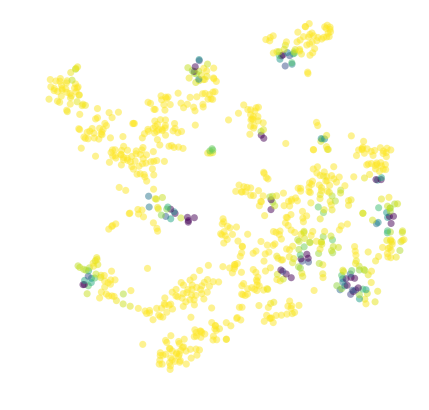

In [256]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=True)
plt.axis("off")
plt.savefig("endpoint_distr_.pdf")

In [257]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

2019-06-20 19:55:56,444 - DEBUG - update_title_pos
2019-06-20 19:55:56,467 - DEBUG - update_title_pos
2019-06-20 19:55:56,475 - DEBUG - update_title_pos
2019-06-20 19:55:56,512 - DEBUG - update_title_pos
2019-06-20 19:55:56,534 - DEBUG - update_title_pos
2019-06-20 19:55:56,548 - DEBUG - update_title_pos


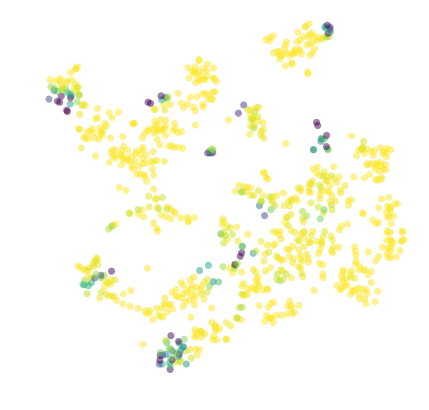

In [258]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=True)
plt.axis("off")
plt.savefig("startpoint_distr_.pdf")

In [259]:
vlm.diffused

array([1.10481959e-03, 6.54438528e-04, 5.06310139e-08, 1.02279711e-03,
       2.06553147e-05, 7.07118170e-04, 6.78632976e-04, 1.54712031e-04,
       1.17102766e-05, 5.48123778e-10, 6.89642001e-03, 2.68730479e-09,
       1.58127812e-04, 8.39485292e-06, 3.41163104e-03, 3.50771783e-06,
       7.10608164e-05, 4.69476161e-04, 2.66048756e-04, 3.65843064e-05,
       2.75819432e-04, 2.08652614e-06, 1.66616460e-06, 2.95641471e-05,
       1.56802437e-05, 1.03846141e-04, 8.58479091e-03, 2.52982660e-05,
       1.29063105e-08, 9.01993143e-05, 1.87981113e-04, 1.97562086e-03,
       2.40388526e-06, 1.05365419e-04, 5.25363844e-08, 3.06632297e-05,
       1.18051786e-04, 4.06876527e-02, 5.41089599e-05, 9.27479098e-09,
       7.94530660e-06, 2.39363869e-04, 7.13658851e-05, 2.03620803e-04,
       2.66722058e-04, 6.73396533e-04, 3.64902579e-05, 2.41036438e-08,
       2.17828933e-05, 3.65401620e-08, 1.22128529e-02, 1.28959230e-04,
       5.53907645e-04, 7.46570134e-09, 9.26015776e-04, 1.40770719e-07,
      